In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import os

from kan import KAN

print("Using PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("Using GPU, device name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("No CUDA found, using CPU instead.")
    device = torch.device("cpu")

Using PyTorch version: 2.2.2
No CUDA found, using CPU instead.


In [4]:
batch_size = 32
epochs = 20
data_dir = "./data"
print("data_dir =", data_dir)

train_dataset = datasets.MNIST(
    f"{data_dir}", train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(
    f"{data_dir}", train=False, download=True, transform=ToTensor()
)

data_dir = ./data


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5)
        x = x.view(-1,3*3*64 )
        return x.detach()


model = CNN()

dsize = 1000

mean = torch.mean(train_dataset.data[:dsize].to(torch.float32))
std = torch.std(train_dataset.data[:dsize].to(torch.float32))
print(f"mean = {mean}, std = {std}")

dataset = {}
dataset["train_input"] = (
    torch.flatten(
        model(((train_dataset.data[:dsize] - mean) / std).unsqueeze(1)).squeeze(1),
        start_dim=1,
    )
    .long()
    .to(device)
)
dataset["test_input"] = (
    torch.flatten(
        model(((test_dataset.data[:dsize] - mean) / std).unsqueeze(1)).squeeze(1),
        start_dim=1,
    )
    .long()
    .to(device)
)

dataset["train_label"] = train_dataset.targets[:dsize].long().to(device)
dataset["test_label"] = test_dataset.targets[:dsize].long().to(device)

print("Train input shape:", dataset["train_input"].shape)
print("Test input shape:", dataset["test_input"].shape)
print("Train label shape:", dataset["train_label"].shape)
print("Test label shape:", dataset["test_label"].shape)

mean = 32.70093536376953, std = 77.81045532226562
Train input shape: torch.Size([1000, 576])
Test input shape: torch.Size([1000, 576])
Train label shape: torch.Size([1000])
Test label shape: torch.Size([1000])


train loss: 1.50e+00 | test loss: 1.50e+00 | reg: 1.41e+03 : 100%|██| 20/20 [01:21<00:00,  4.07s/it]


Test accuracy: 0.13300000131130219


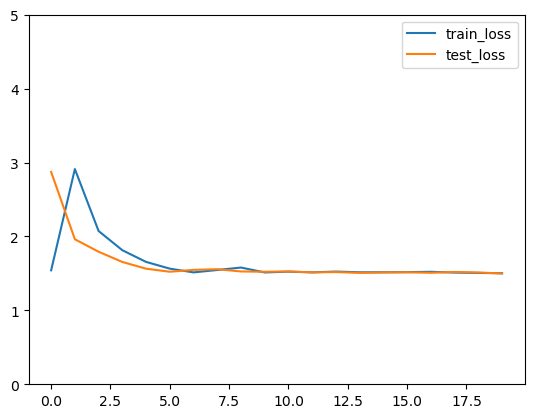

In [9]:
model = KAN(width=[dataset["train_input"].shape[1], 20, 10], grid=5, k=3)

def train_acc():
    # model for some reason is on cpu only here, something about KAN's implementation
    try:
        arg = (
            torch.argmax(model(dataset["train_input"]), dim=1) == dataset["train_label"]
        )

    except:
        arg = torch.argmax(model(dataset["train_input"].to("cpu")), dim=1) == dataset[
            "train_label"
        ].to("cpu")
    return torch.mean(arg.float())


def test_acc():
    try:
        arg = torch.argmax(model(dataset["test_input"]), dim=1) == dataset["test_label"]
    except:
        arg = torch.argmax(model(dataset["test_input"].to("cpu")), dim=1) == dataset[
            "test_label"
        ].to("cpu")

    return torch.mean(arg.float())


loss_fn = torch.nn.CrossEntropyLoss()

result = model.train(
    dataset,
    opt="Adam",
    steps=epochs,
    lr=0.5,
    batch=512,
    loss_fn=loss_fn,
)

acc = test_acc()
print(f"Test accuracy: {acc.item()}")

plt.plot(result["train_loss"], label="train_loss")
plt.plot(result["test_loss"], label="test_loss")
plt.ylim(0, 5)
plt.legend()

# 'Beta' controls the transparency of activations.
# Larger 'Beta' => more activation functions show up. We usually want to set a proper beta such that only important connections are visually significant.
# model.prune()
# model.plot(mask=True, beta=3)

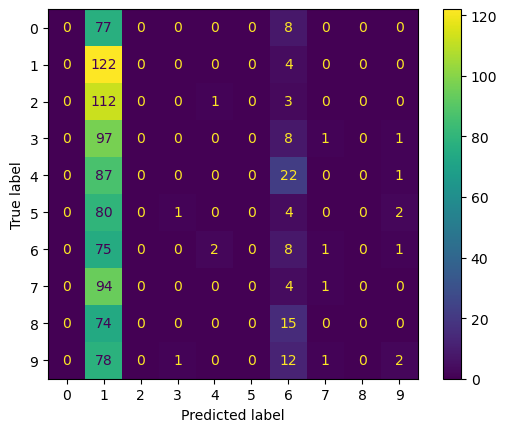

In [10]:
test_predictions = np.argmax(model(dataset["test_input"]).detach().numpy(),axis=1)
test_labels = dataset["test_label"]

labels_ = [i for i in range(10)]
cm = confusion_matrix(test_labels, test_predictions, labels=labels_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_)
disp.plot()
plt.show()
